In [14]:
import os
import csv
import numpy as np
import pandas as pd
import matplotlib
from scipy import stats
import reverse_geocode
from collections import defaultdict
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

In [6]:
# data_root = '/shared/0/projects/news-quotes/'
data_root = "/kellogg/proj/hpk5609/Mentions/"

In [3]:
CIs = {'90': 1.645, '95': 1.96, '99': 2.576}

In [4]:
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_colwidth', 1000)

In [11]:
def get_path(filename):
    '''return absolute file path'''
    return os.path.join(data_root, filename)

def yield_one_line(filename, delimiter = '\t', quote = csv.QUOTE_NONE):
    '''a generator which produce one line of a given file'''
    filepath = get_path(filename)
    with open(filepath, 'r') as file:
        print('processing %s...' %(filepath))
        reader = csv.reader(file, delimiter=delimiter, quoting=quote)
        for row in reader:
            yield row

In [7]:
reg_data = pd.read_csv(data_root+"reg_data_plot.csv", header=0)

In [9]:
reg_data.columns

Index(['has_indirect_mention', 'mentions_author_institution',
       'has_author_quote', 'url', 'doi', 'author_id', 'affiliation_ids',
       'author_seq_num', 'author_name', 'author_pos_cate', 'author_last_name',
       'last_name_length', 'last_name_prob', 'author_eth_ethnea',
       'author_gender_ethnea', 'author_eth_wiki', 'author_eth_census',
       'reporter_name', 'reporter_eth_ethnea', 'reporter_gender_ethnea',
       'reporter_eth_wiki', 'reporter_eth_census', 'Publication Date',
       'Mention Date', 'doi_men_cn', 'author_rank', 'affiliation_name',
       'affiliation_cate', 'affiliation_rank', 'journal_title',
       'journal_impact', 'top_journal', 'num_authors', 'outlet', 'category',
       'num_words', 'num_mentioned_papers', 'mention_year', 'gap_in_years',
       'is_author_mentioned', 'FleschReadingEase', 'sentences_per_paragraph',
       'type_token_ratio', 'author_eth_ethnea_broad',
       'reporter_eth_ethnea_broad', 'author_eth_wiki_broad',
       'reporter_eth_wi

In [35]:
dois_date = dict(zip(reg_data.doi, reg_data['Publication Date']))
urls_date = dict(zip(reg_data.url, reg_data['Mention Date']))

In [36]:
urls = list(set(reg_data['url'].tolist()))
dois = list(set(reg_data['doi'].tolist()))

In [37]:
print('num. of unique news articles: %d'%len(urls))
print('num. of unique journal papers: %d'%len(dois))
print('num. of triplets: %d'%len(reg_data))

num. of unique news articles: 223587
num. of unique journal papers: 100486
num. of triplets: 524052


In [38]:
# story-paper pairs
len(reg_data[['doi', 'url']].drop_duplicates())

276202

In [39]:
# paper authorships
reg_data[['doi', 'author_name', 'author_eth_ethnea_broad']].drop_duplicates().author_eth_ethnea_broad.value_counts()

English                    81226
WesternNorthernEuropean    39007
SouthernEuropean           19109
Chinese                    16054
MiddleEastern               9185
EastAsian                   7816
Indian                      7505
EasternEuropean             6315
African                     1079
unknown                      898
Name: author_eth_ethnea_broad, dtype: int64

In [40]:
# total paper authorships
len(reg_data[['doi', 'author_name', 'author_eth_ethnea_broad']].drop_duplicates())

188194

In [41]:
# num. of triplets
reg_data.author_eth_ethnea_broad.value_counts()

English                    234510
WesternNorthernEuropean    106331
SouthernEuropean            51134
Chinese                     43039
MiddleEastern               26082
Indian                      21314
EastAsian                   19068
EasternEuropean             17251
African                      2774
unknown                      2549
Name: author_eth_ethnea_broad, dtype: int64

In [46]:
# num. of triplets
reg_data.author_eth_ethnea_broad.value_counts() / len(reg_data)

author_eth_ethnea_broad
English                    0.447494
WesternNorthernEuropean    0.202902
SouthernEuropean           0.097574
Chinese                    0.082127
MiddleEastern              0.049770
Indian                     0.040672
EastAsian                  0.036386
EasternEuropean            0.032918
African                    0.005293
unknown                    0.004864
Name: count, dtype: float64

In [57]:
# num. of triplets
f_obs = (reg_data.author_eth_ethnea_broad.value_counts() / len(reg_data)).tolist()

In [63]:
# see `get_reg_data_risk_authors.ipynb`

f_exp = [0.4418279490764589,
 0.20452445568348138,
 0.10403096384404796,
 0.07879367670375102,
 0.04885115783636646,
 0.04104701440782094,
 0.03650085370594606,
 0.03416905087373849,
 0.005328136022079653,
 0.0049267418463091435]

In [65]:
stats.chisquare(f_obs=f_obs, f_exp=f_exp)

Power_divergenceResult(statistic=0.0006951802789119887, pvalue=1.0)

In [42]:
reg_data.reporter_eth_ethnea_broad.value_counts()

unknown                    418187
English                     68652
WesternNorthernEuropean     13790
SouthernEuropean            10594
MiddleEastern                3494
EasternEuropean              2924
Chinese                      2449
Indian                       2409
EastAsian                     910
African                       643
Name: reporter_eth_ethnea_broad, dtype: int64

overall mention rate

In [43]:
reg_data.is_author_mentioned.mean()

0.41243235404120204

mention rate per outlet type

In [44]:
len(set(reg_data.outlet))

288

In [45]:
reg_data.category.value_counts()

General         220858
PressRelease    165343
SciTech         137851
Name: category, dtype: int64

In [46]:
for cate, gp in reg_data.groupby('category'):
    total = len(gp)
    positive = np.sum(gp.is_author_mentioned)
    print(cate, '&', len(set(gp.outlet.values)), '&', total, '&', positive/total)

General & 181 & 220858 & 0.2419744813409521
PressRelease & 21 & 165343 & 0.6348802186968907
SciTech & 86 & 137851 & 0.41872021240324697


mention rate by location

In [34]:
for cate, gp in reg_data.groupby('affiliation_cate'):
    total = len(gp)
    positive = np.sum(gp.is_author_mentioned)
    print(cate, '\t', total, '\t', positive/total)

domestic 	 317626 	 0.4421930194631422
international 	 205686 	 0.3667191738864094
unknown 	 740 	 0.34459459459459457


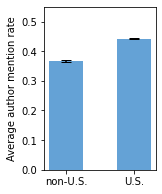

In [42]:
# nrows = 1
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2, 3))

cates = ['international', 'domestic']
re_cates = ['non-U.S.', 'U.S.']

s = 3 # markersize
lw = 1.5 # linewidth
xpos = np.arange(len(cates))
ys = [np.mean(reg_data.loc[reg_data['affiliation_cate'] == cate]['is_author_mentioned']) for cate in cates]
stds = [np.std(reg_data.loc[reg_data['affiliation_cate'] == cate]['is_author_mentioned']) for cate in cates]
lilen = [len(reg_data.loc[reg_data['affiliation_cate'] == cate]) for cate in cates]
ax.bar(xpos, ys, yerr = CIs['95']*(stds/np.sqrt(lilen)), width = 0.5, color = '#3D8BCC', alpha = 0.8, capsize = 5)

# ax.set_yscale('log')
# ax.set_xlabel('# of mentions')
ax.set_ylabel('Average author mention rate')
ax.set_xticks(xpos)
ax.set_xticklabels(re_cates)
ax.yaxis.grid(False)
ax.set_ylim([0, 0.55])
# ax.ticklabel_format(axis='y', style='sci', scilimits=(2, 2))
# ax.yaxis.major.formatter._useMathText = True
    
plt.show()
fig.savefig(data_root+'loc_rate_raw.pdf', bbox_inches='tight', pad_inches=0.02)

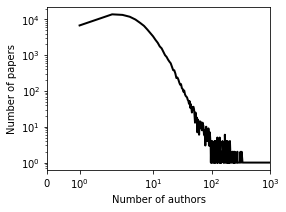

In [23]:
nrows = 1
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4, 3))


reg_data_tem = reg_data[['doi', 'num_authors']]
reg_data_tem = reg_data_tem.drop_duplicates()

cns = list(reg_data_tem.num_authors.values)
c = Counter(cns)
x, y = [], []
for k in sorted(c.keys()):
    x.append(float(k))
    y.append(float(c[k]))
ax.plot(x, y, c = 'black', linewidth = 2, alpha = 1)
ax.set_xscale('symlog')
ax.set_yscale('log')
ax.set_ylabel('Number of papers')
ax.set_xlabel('Number of authors')
ax.set_xlim([0, 1000])
plt.show()
fig.savefig(data_root+'num_author.pdf', bbox_inches='tight', pad_inches=0.02)

In [51]:
reg_data_tem = reg_data[['url', 'num_words', 'category']]
reg_data_tem = reg_data_tem.drop_duplicates()

In [52]:
len(reg_data_tem)

223587

In [53]:
cate_word_cn_li = {}
for cate, gp in reg_data_tem.groupby('category'):
    cate_word_cn_li[cate] = gp['num_words'].tolist()

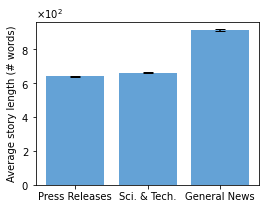

In [54]:
# nrows = 1
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4, 3))

# cates = ['Academic', 'MSM', 'Science', 'Periodical']
# re_cates = ['Academic\nReports', 'National\nNews', 'Science\nMag.', 'General\nMag.']

cates = ['PressRelease', 'SciTech', 'General']
re_cates = ['Press Releases', 'Sci. & Tech.', 'General News']

s = 3 # markersize
lw = 1.5 # linewidth
xpos = np.arange(len(cates))
ys = [np.mean(cate_word_cn_li[cate]) for cate in cates]
stds = [np.std(cate_word_cn_li[cate]) for cate in cates]
lilen = [len(cate_word_cn_li[cate]) for cate in cates]
ax.bar(xpos, ys, yerr = CIs['95']*(stds/np.sqrt(lilen)), color = '#3D8BCC', alpha = 0.8, capsize = 5)

# ax.set_yscale('log')
# ax.set_xlabel('# of mentions')
ax.set_ylabel('Average story length (# words)')
ax.set_xticks(xpos)
ax.set_xticklabels(re_cates)
ax.yaxis.grid(False)
ax.ticklabel_format(axis='y', style='sci', scilimits=(2, 2))
ax.yaxis.major.formatter._useMathText = True
    
plt.show()
fig.savefig(data_root+'news_length.pdf', bbox_inches='tight', pad_inches=0.02)

/opt/anaconda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


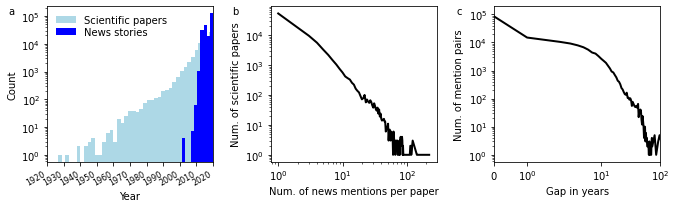

In [31]:
nrows = 1
ncols = 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(9.5, 3))

s = 3 # markersize
lw = 1.5 # linewidth

# (a)
ax = axes[0]
date_li = [dtt for dtt in list(dois_date.values())]
mpl_data = mdates.datestr2num(date_li)
ax.hist(mpl_data, bins=50, color='lightblue', alpha = 1, label='Scientific papers')

date_li = [dtt for dtt in list(urls_date.values())]
mpl_data = mdates.datestr2num(date_li)
ax.hist(mpl_data, bins=10, color = 'blue', alpha = 1, label='News stories')

legend = ax.legend(loc='best', numpoints=2, labelspacing = 0.15, shadow=False, frameon = False, markerscale = 1)
for label in legend.get_texts():
    label.set_fontsize(10)
for label in legend.get_lines():
    label.set_linewidth(1)
    
locator = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator))
ax.set_xlim([datetime(1920, 1, 1), datetime(2020, 1, 1)])

for tick in ax.get_xticklabels():
    tick.set_ha('right')
    tick.set_fontsize(8)
    tick.set_rotation(30)
    
ax.set_yscale('log')
ax.set_ylabel('Count')
ax.set_xlabel('Year')

# (b)
ax = axes[1]
# cns = [cn for doi, cn in reg_data.doi.value_counts().items()]
cns = [cn for doi, cn in reg_data[['url', 'doi']].drop_duplicates().doi.value_counts().items()]
c = Counter(cns)
x, y = [], []
for k in sorted(c.keys()):
    x.append(float(k))
    y.append(float(c[k]))
ax.plot(x, y, c = 'black', linewidth = 2, alpha = 1)
# ax.hist(cns, bins=2000, color='lightblue')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Num. of news mentions per paper')
ax.set_ylabel('Num. of scientific papers')

# (c)
ax = axes[2]
# cns = list(reg_data.gap_in_years.values)
cns = list(reg_data[['url', 'doi', 'gap_in_years']].drop_duplicates().gap_in_years.values)
c = Counter(cns)
x, y = [], []
for k in sorted(c.keys()):
    x.append(float(k))
    y.append(float(c[k]))
ax.plot(x, y, c = 'black', linewidth = 2, alpha = 1)
ax.set_xscale('symlog')
ax.set_yscale('log')
ax.set_ylabel('Num. of mention pairs')
ax.set_xlabel('Gap in years')
ax.set_xlim([0, 100])

# labels
    
for ax, label in zip(axes, ['a', 'b', 'c']):
    ax.text(-0.23, 1.0, label, ha='left', va='top', transform=ax.transAxes)

plt.tight_layout()
# plt.subplots_adjust(wspace=0)
plt.show()
fig.savefig(data_root+'data_one.pdf', bbox_inches='tight', pad_inches=0.02)